## Work Trial Task by DONAIRE

In [5]:
import pandas as pd

df = pd.read_csv("merged_data.csv")

df.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


## 1

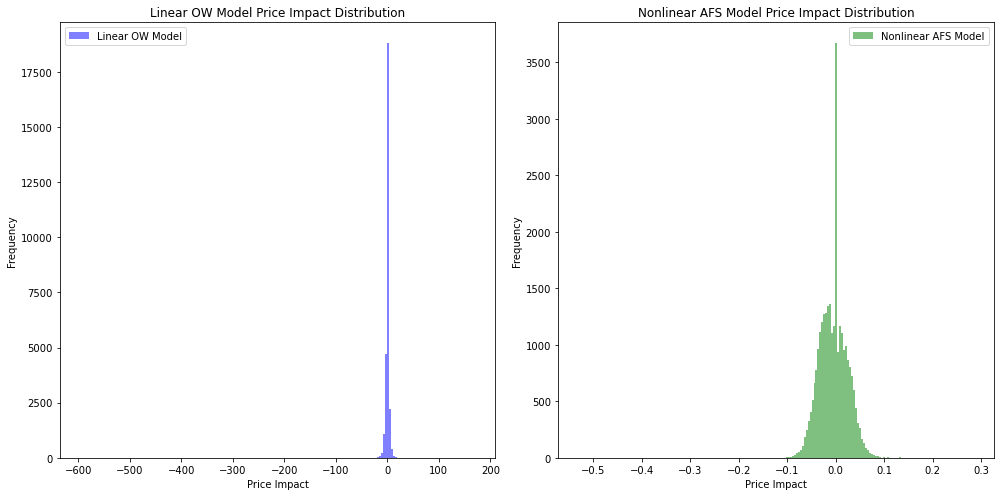

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the models
lambda_p = 0.0035  # impact level
beta = 2  # decay rate for the kernel
p = 0.5  # nonlinearity parameter for AFS model

# Linear OW Model
def linear_ow_model(volume, t):
    h_x = lambda_p * volume
    K_t = np.exp(-beta * t)
    return h_x * K_t

# Nonlinear AFS Model
def nonlinear_afs_model(volume, t):
    h_x = lambda_p * np.sign(volume) * np.abs(volume)**p
    K_t = np.exp(-beta * t)
    return h_x * K_t

# Preprocess data: calculate time differences (assuming sorted timestamps)
df['t'] = (pd.to_datetime(df['ts_event']).diff().dt.total_seconds()).fillna(0)

# Calculate price impacts for both models
df['linear_ow_impact'] = linear_ow_model(df['Signed Volume'], df['t'])
df['nonlinear_afs_impact'] = nonlinear_afs_model(df['Signed Volume'], df['t'])

# Visualize the distributions of price impacts
plt.figure(figsize=(14, 7))

# Linear OW model distribution
plt.subplot(1, 2, 1)
plt.hist(df['linear_ow_impact'], bins=200, color='blue', alpha=0.5, label='Linear OW Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.title('Linear OW Model Price Impact Distribution')
plt.legend()

# Nonlinear AFS model distribution
plt.subplot(1, 2, 2)
plt.hist(df['nonlinear_afs_impact'], bins=200, color='green', alpha=0.5, label='Nonlinear AFS Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.title('Nonlinear AFS Model Price Impact Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## 2

In [153]:
# Load the data
data = pd.read_csv("merged_data.csv")

# Define parameters for the strategy computation based on the paper
alpha = 0.000167  
beta = 4
lambda_param = 0.01
gamma = 10  
sigma_sq = (0.02)**2 
phi = 0.139 

# Compute coefficients C_f and C_J from the given equations
Cf = (alpha * (1 + beta/phi)) / (gamma * sigma_sq * (np.sqrt(1 + (2 * lambda_param * beta) / (gamma * sigma_sq)) + beta/phi))
CJ = np.sqrt(1 + (2 * lambda_param * beta) / (gamma * sigma_sq)) - 1

# Calculate the exponential moving average J_t for Signed Volume (f_t)
data['J_t'] = data['Signed Volume'].ewm(span=int(beta), adjust=False).mean()

# Compute the optimal strategy Q_t*
data['Q_t_star'] = Cf * data['Signed Volume'] - CJ * data['J_t']

# Display the first few rows with the computed strategy
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price,J_t,Q_t_star
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985,-1198.0000,4247.280594
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980,-719.2000,2576.551173
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970,-351.5200,1266.800278
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030,-157.3120,568.575839
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035,-135.1872,480.517209


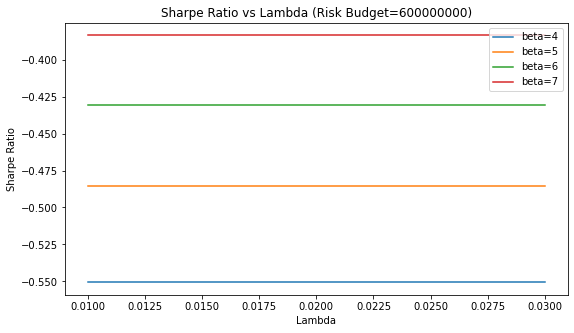

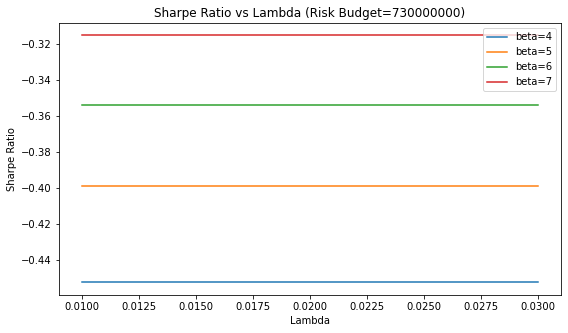

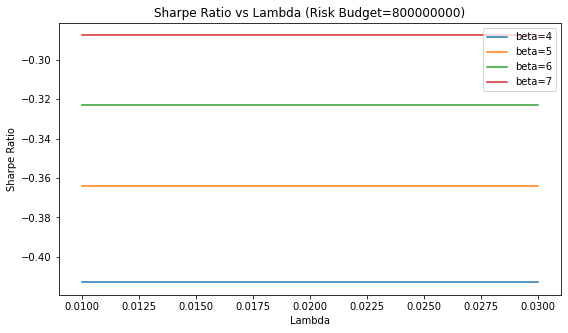

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("merged_data.csv")

# Define constants
alpha = 0.00167  
phi = 0.139  
sigma_sq = (0.02)**2

# Define parameter ranges
lambdas = [0.01, 0.02, 0.03]
betas = [4, 5, 6, 7]
risk_budgets = [600*1000000, 730*1000000, 800*1000000]  # DR values

# Placeholder for results
results = []

for beta in betas:
    # Compute J_t using an exponential moving average
    data['J_t'] = data['Signed Volume'].ewm(span=beta, adjust=False).mean()
    
    for lambda_ in lambdas:
        # Compute coefficients C_f and C_J
        Cf = (alpha * (1 + beta/phi)) / (gamma * sigma_sq * (np.sqrt(1 + (2 * lambda_param * beta) / (gamma * sigma_sq)) + beta/phi))
        CJ = np.sqrt(1 + (2 * lambda_param * beta) / (gamma * sigma_sq)) - 1

        # Compute the optimal strategy Q_t*
        data['Q_t_star'] = Cf * data['Signed Volume'] - CJ * data['J_t']

        # Compute the reward (PnL) r = Q_t^* * f_t
        data['PnL'] = data['Q_t_star'] * data['Signed Volume']

        # Compute mean and variance of PnL
        mean_pnl = data['PnL'].mean()

        # Loop over different risk budgets
        for risk_budget in risk_budgets:
            # Risk (DR) is directly given by the budget
            risk = risk_budget

            # Compute Sharpe Ratio = PnL / Risk
            sharpe_ratio = mean_pnl / risk if risk != 0 else 0

            # Store results
            results.append((lambda_, beta, risk_budget, sharpe_ratio))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["lambda", "beta", "risk_budget", "sharpe_ratio"])

# Plot Sharpe ratio vs lambda for each risk budget and beta
for risk_budget in risk_budgets:
    plt.figure(figsize=(9, 5))
    for beta in betas:
        subset = results_df[(results_df['beta'] == beta) & (results_df['risk_budget'] == risk_budget)]
        plt.plot(subset['lambda'], subset['sharpe_ratio'], label=f"beta={beta}")

    plt.xlabel("Lambda")
    plt.ylabel("Sharpe Ratio")
    plt.title(f"Sharpe Ratio vs Lambda (Risk Budget={risk_budget})")
    plt.legend()
    plt.show()


## 3

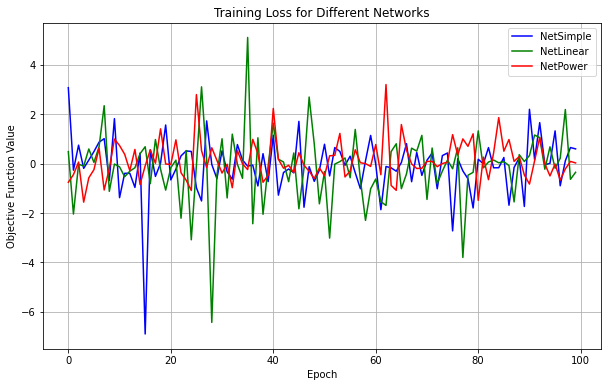

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define NL function from equation (C.20)
def NL(x, p=2, B=1.0, a=1.0, b=0.0):
    abs_x = torch.abs(x)
    sign_x = torch.sign(x)
    return torch.where(
        abs_x < B,
        sign_x * abs_x**(1 / p),
        a * x + sign_x * b
    )

# Define networks (NetSimple, NetLinear, NetPower)
class NetSimple(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NetSimple, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class NetLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(NetLinear, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.fc(x)

class NetPower(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, p=2):
        super(NetPower, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.p = p

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.pow(x, self.p)

# Function to train a network and return loss values
def train_network(network, input_size, num_epochs, learning_rate):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        # Generate example data
        fn = torch.randn(1, 1)  # Current signal
        Jn0_prev = torch.randn(1, 1)  # Previous moving average

        # Forward pass
        input_data = torch.cat((fn, Jn0_prev), dim=1)
        NN_output = network(input_data)

        # Apply nonlinear transformation (NL)
        Qn = NL(NN_output - Jn0_prev, p=2, B=1.0, a=1.0, b=0.0)

        # Update moving average Jn0
        beta = 0.1
        exp_beta = torch.exp(torch.tensor(-beta))  # Convert beta to tensor
        Jn0 = exp_beta * Jn0_prev + (1 - exp_beta) * Qn

        # Objective function (C.17)
        gamma = 0.01
        lambda_ = 0.1
        sigma = 0.2
        objective = (
            -torch.mean(fn * Qn)
            - gamma / 2 * torch.mean((Qn**2) * sigma**2)
            - lambda_ * torch.mean(torch.abs(Jn0))
        )

        # Record loss
        losses.append(objective.item())

        # Backpropagation
        optimizer.zero_grad()
        objective.backward()
        optimizer.step()

    return losses

# Parameters
input_size = 2
output_size = 1
hidden_sizes = [128, 32, 8]
learning_rate = 0.01
num_epochs = 100

# Instantiate networks
net_simple = NetSimple(input_size, hidden_sizes, output_size)
net_linear = NetLinear(input_size, output_size)
net_power = NetPower(input_size, hidden_sizes, output_size, p=2)

# Train networks and collect losses
losses_simple = train_network(net_simple, input_size, num_epochs, learning_rate)
losses_linear = train_network(net_linear, input_size, num_epochs, learning_rate)
losses_power = train_network(net_power, input_size, num_epochs, learning_rate)

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(losses_simple, label='NetSimple', color='blue')
plt.plot(losses_linear, label='NetLinear', color='green')
plt.plot(losses_power, label='NetPower', color='red')
plt.title('Training Loss for Different Networks')
plt.xlabel('Epoch')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid()
plt.show()